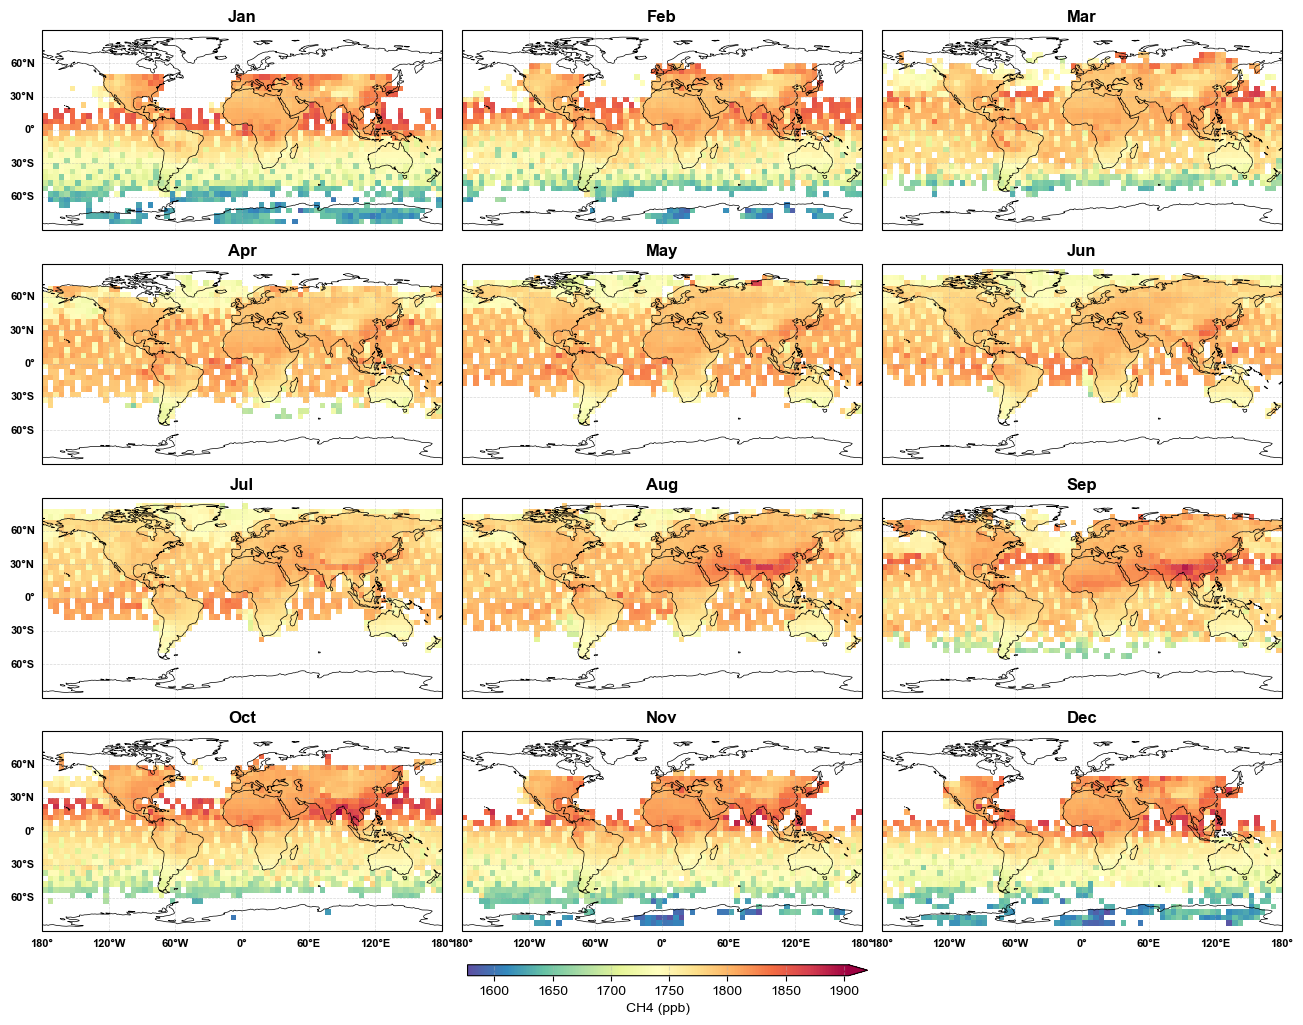

In [30]:
# --- 1.1 计算甲烷气候平均值并绘图 ---
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER 

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

# --- 数据加载 ---
FILE_PATH = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'

ds = xr.open_dataset(FILE_PATH)
xch4 = ds['xch4'] * 1e9

climatology = xch4.groupby('time.month').mean('time')

# 创建图形和子图
fig, axes = plt.subplots(4, 3, figsize=(16, 11), 
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 获取数据范围
vmin = climatology.min().item()
vmax = climatology.max().item()

# 绘制每个月份
for i in range(12):
    ax = axes[i]
    month_data = climatology.sel(month=i+1)
    
    # 绘制填色图
    im = ax.pcolormesh(ds.lon, ds.lat, month_data,
                       cmap='Spectral_r', vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree())
    
    # 添加海岸线
    ax.coastlines(linewidth=0.5)
    
    # 设置标题
    ax.set_title(f'{months[i]}', fontsize=12, fontweight='bold')
    
    # 配置网格线
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    
    # 默认关闭所有标签
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    
    # 只有第一列显示纬度标签
    if i % 3 == 0:  # 第一列: 索引 0, 3, 6, 9
        gl.left_labels = True
        gl.ylabel_style = {'size': 8}
    
    # 只有最后一行显示经度标签
    if i >= 9:  # 最后一行: 索引 9, 10, 11
        gl.bottom_labels = True
        gl.xlabel_style = {'size': 8}

    gl.xlabel_style = {'size': 8, 'fontweight': 'bold'}
    gl.ylabel_style = {'size': 8, 'fontweight': 'bold'}

# 添加颜色条
cbar_ax = fig.add_axes([0.391, 0.07, 0.25, 0.01])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='CH4 (ppb)', 
             extend='max')

# 调整布局
plt.subplots_adjust(bottom=0.08, top=0.94, hspace=0.05, wspace=0.05)
plt.subplots_adjust(bottom=0.1)  # 为颜色条留出空间

plt.show()

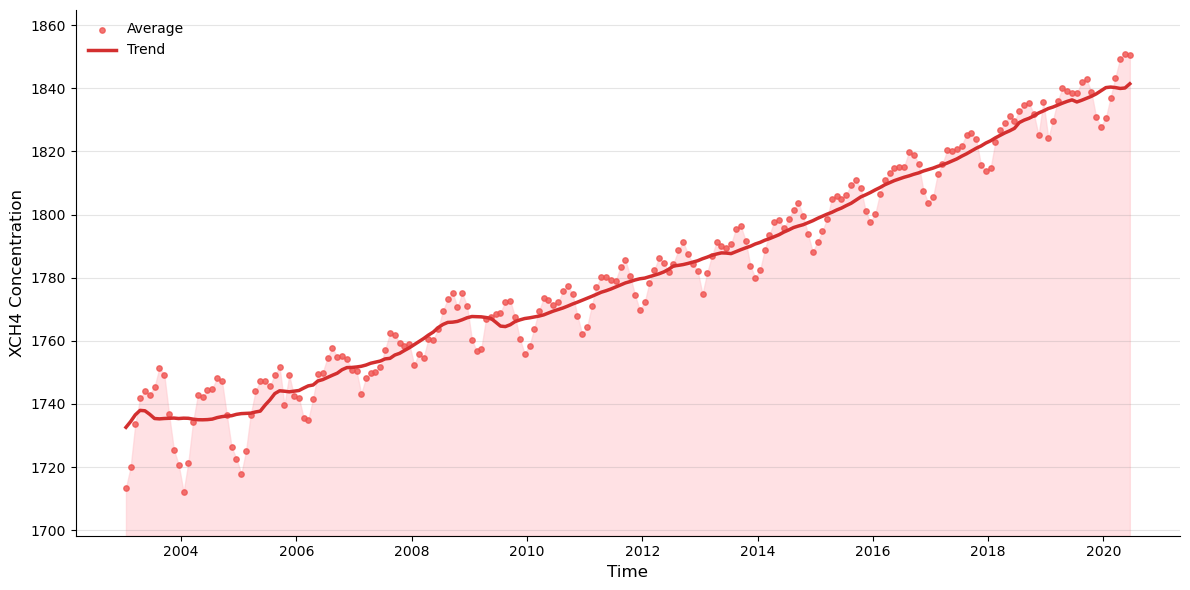

In [48]:
# --- 1.2---

# --- 1. 计算加权平均 (保持不变) ---

global_mean = global_mean_raw

# --- 2. 填充空缺值 (新增步骤) ---
# 使用线性插值填充时间序列中的 NaN 值
global_mean_filled = global_mean.interpolate_na(dim='time', method='linear')

# --- 3. 准备绘图数据 ---
# 基于填充后的数据计算滑动平均 (Trend)
trend = global_mean_filled.rolling(time=12, center=True, min_periods=1).mean()

# --- 4. 动态计算 Y 轴范围 ---
y_min = global_mean_filled.min().values
y_max = global_mean_filled.max().values
y_range = y_max - y_min

# 设置填充的底线 
y_bottom = y_min - (y_range * 0.1)
y_top = y_max + (y_range * 0.1)

# --- 5. 绘图 ---
plt.style.use('default') 
fig, ax = plt.subplots(figsize=(12, 6))

# 颜色定义
col_trend = '#D32F2F' 
col_dots = '#EF5350' 
col_fill = '#FFCDD2' 

# 5.1 绘制填充 (使用填充后的数据，保证连续)
ax.fill_between(global_mean_filled.time, y_bottom, global_mean_filled.values, color=col_fill, alpha=0.6)

# 5.2 绘制散点 
ax.scatter(global_mean_filled.time, global_mean_filled.values, color=col_dots, s=15, label='Average', zorder=2, alpha=0.8)

# 5.3 绘制趋势线
ax.plot(global_mean_filled.time, trend.values, color=col_trend, linewidth=2.5, label='Trend', zorder=3)

# --- 6. 设置样式 ---
ax.set_ylabel('XCH4 Concentration', fontsize=12, color='black')
ax.set_xlabel('Time', fontsize=12, color='black')

# 设置轴范围
ax.set_ylim(y_bottom, y_top)

# 网格与边框
ax.grid(axis='y', color='gray', linestyle='-', alpha=0.2)
ax.grid(axis='x', visible=False) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# 刻度颜色
ax.tick_params(axis='both', colors='black')

# 图例 
legend = ax.legend(loc='upper left', frameon=False, fontsize=10)

plt.tight_layout()
plt.show()

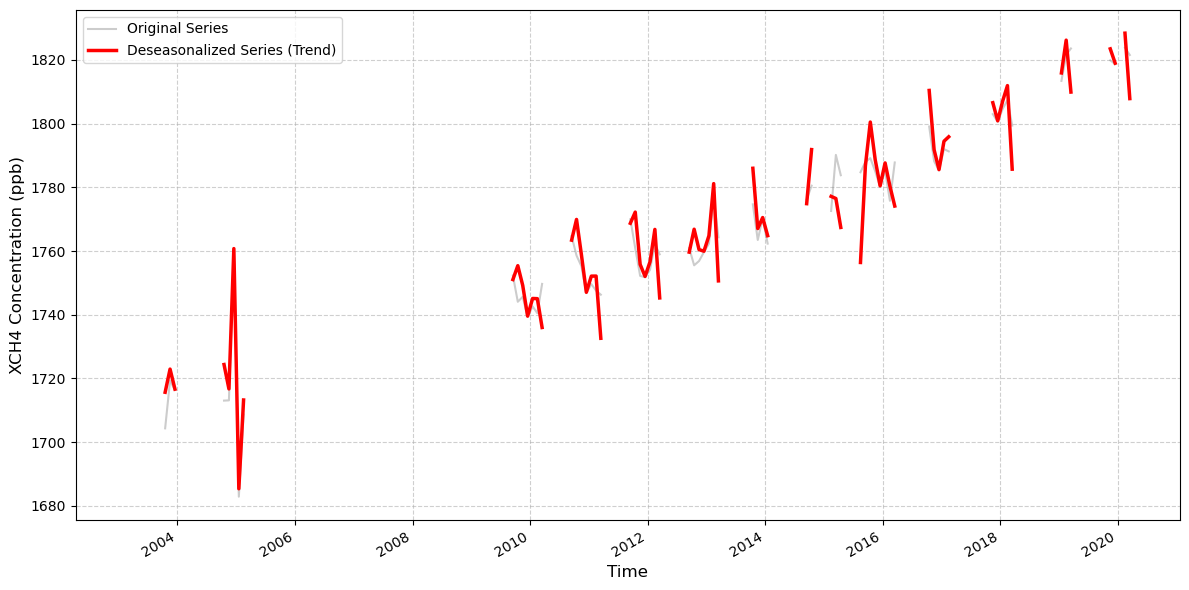

In [49]:

# 1.3 南太平洋指定点位甲烷浓度去季节化时间序列

# 1. 选取指定点位 (15°S, 150°W) 的时间序列
# 使用 method='nearest' 选取最近的格点
point_lat = -15
point_lon = -150
point_data = xch4.sel(lat=point_lat, lon=point_lon, method='nearest')


# 2. 计算该点位的月平均气候值 (Seasonal Climatology)
point_clim = point_data.groupby('time.month').mean('time')

# 3. 进行去季节化处理
# Deseasonalized = Original - Climatology + Long-term Mean
point_deseasonalized = point_data.groupby('time.month') - point_clim

# 为了让去季节化后的值保持在正确的数值范围内，加上原始序列的长期平均值
point_deseasonalized = point_deseasonalized + point_data.mean()


# 4. 绘图
fig3, ax3 = plt.subplots(figsize=(12, 6))

# 绘制原始序列 (作为背景参考)
point_data.plot(ax=ax3, 
                label='Original Series', 
                alpha=0.4, 
                color='gray', 
                linewidth=1.5)

# 绘制去季节化后的序列 (突出趋势)
point_deseasonalized.plot(ax=ax3, 
                          label='Deseasonalized Series (Trend)', 
                          linewidth=2.5, 
                          color='red')


ax3.set_ylabel('XCH4 Concentration (ppb)', fontsize=12)
ax3.set_xlabel('Time', fontsize=12)
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.tick_params(labelsize=10)
ax3.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

In [50]:
#2
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

def calculate_nino34_index():    
    # 读取数据
    ds = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')
    sst = ds['sst']
    print(f"数据维度: {sst.dims}")
    print(f"时间范围: {sst.time.min().values} 到 {sst.time.max().values}")
    
    # 定义Niño 3.4区域: 5°N-5°S, 120°W-170°W
    # 注意经度转换: 120°W = 240°E, 170°W = 190°E
    nino34_region = sst.sel(lat=slice(-5, 5), lon=slice(190, 240))
    print(f"Niño 3.4区域范围: 纬度{-5}°到{5}°, 经度{190}°到{240}°")
    
    # 计算区域平均
    nino34_ts = nino34_region.mean(dim=['lat', 'lon'])
    print(f"区域平均SST计算完成，时间点数量: {len(nino34_ts)}")
    
    # 计算月气候态 (使用1981-2010作为基准期)
    clim_period = slice('1981-01-01', '2010-12-31')
    climatology = nino34_ts.sel(time=clim_period).groupby('time.month').mean()
    print(f"气候基准期: 1981-2010，已计算12个月的气候平均")
    
    # 计算异常值
    nino34_anom = nino34_ts.groupby('time.month') - climatology
    print("异常值计算完成")
    
    # 打印统计信息
    print("\n=== Niño 3.4指数统计信息 ===")
    print(f"平均异常值: {nino34_anom.mean().values:.3f}°C")
    print(f"最大异常值: {nino34_anom.max().values:.3f}°C")
    print(f"最小异常值: {nino34_anom.min().values:.3f}°C")
    print(f"标准差: {nino34_anom.std().values:.3f}°C")
    
    # 计算El Niño和La Niña事件数量
    el_nino_months = (nino34_anom >= 0.5).sum().values
    la_nina_months = (nino34_anom <= -0.5).sum().values
    print(f"El Niño月数(≥0.5°C): {el_nino_months}")
    print(f"La Niña月数(≤-0.5°C): {la_nina_months}")
    
    return nino34_anom, nino34_ts, climatology

nino34_anom, nino34_ts, climatology = calculate_nino34_index()

数据维度: ('time', 'lat', 'lon')
时间范围: 1960-01-15T00:00:00.000000000 到 2016-12-15T00:00:00.000000000
Niño 3.4区域范围: 纬度-5°到5°, 经度190°到240°
区域平均SST计算完成，时间点数量: 684
气候基准期: 1981-2010，已计算12个月的气候平均
异常值计算完成

=== Niño 3.4指数统计信息 ===
平均异常值: -0.090°C
最大异常值: 2.658°C
最小异常值: -2.264°C
标准差: 0.858°C
El Niño月数(≥0.5°C): 159
La Niña月数(≤-0.5°C): 227


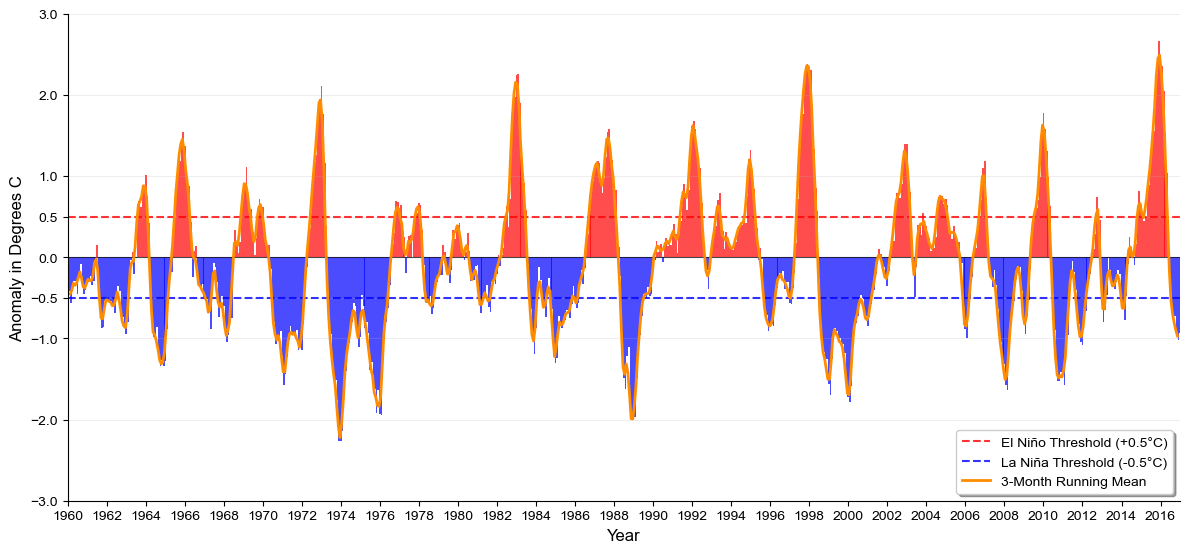

In [52]:
# 第二问：使用柱状图绘制Niño 3.4指数（无空隙、无边框、Arial字体版本）
def plot_nino34_bar_chart_final(nino34_anom):

    # 设置全局字体为Arial
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 提取时间序列数据
    time = nino34_anom.time.values
    values = nino34_anom.values
    
    
    # 计算3个月滑动平均
    nino34_3month = nino34_anom.rolling(time=3, center=True).mean()
    
    # 绘制零线
    ax.axhline(y=0, color='black', linewidth=0.8, alpha=0.7)
    
    # 绘制阈值线
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8, label='El Niño Threshold (+0.5°C)')
    ax.axhline(y=-0.5, color='blue', linestyle='--', linewidth=1.5, alpha=0.8, label='La Niña Threshold (-0.5°C)')
    
   
    colors = ['red' if val >= 0 else 'blue' for val in values]
    time_num = mdates.date2num(time)
    if len(time_num) > 1:
        time_interval = time_num[1] - time_num[0]
        # 设置柱状图宽度等于时间间隔，消除空隙
        bar_width = time_interval
    else:
        bar_width = 30  # 默认宽度（30天）
    
    # 绘制无空隙无边框柱状图
    bars = ax.bar(time_num, values, width=bar_width, color=colors, alpha=0.7, 
                  edgecolor='none', linewidth=0, align='edge')
    
    # 绘制3个月滑动平均曲线
    ax.plot(time, nino34_3month.values, color='darkorange', linewidth=2, label='3-Month Running Mean')
    
    # 设置标题和标签 - 使用Arial字体
    ax.set_ylabel('Anomaly in Degrees C', fontsize=12, fontname='Arial')
    ax.set_xlabel('Year', fontsize=12, fontname='Arial')
    
    # 设置Y轴范围和刻度
    ax.set_ylim(-3, 3)
    ax.set_yticks([-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3])
    
    # 设置X轴范围和刻度 - 只显示2000年以后
    time_min = nino34_anom.time.min().values
    time_max = nino34_anom.time.max().values
    
    # 确保从1960年开始
    start_year = max(1960, pd.to_datetime(time_min).year)
    end_year = pd.to_datetime(time_max).year
    
    ax.set_xlim(np.datetime64(f'{start_year}-01-01'), np.datetime64(f'{end_year}-12-31'))
    
    # 每2年设置一个刻度，使X轴更清晰
    ticks = pd.date_range(f'{start_year}-01-01', f'{end_year}-12-31', freq='2YS')
    ax.set_xticks(ticks)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # 设置刻度标签字体为Arial
    for label in ax.get_xticklabels():
        label.set_fontname('Arial')
    for label in ax.get_yticklabels():
        label.set_fontname('Arial')
    
    # 添加网格
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')
    
    # 移除 spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
    # 添加图例 - 放在右下角
    ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True, fontsize=10)
    
    
    # 调整布局
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    return fig, ax

# 执行第二问：使用最终版本绘图
fig, ax = plot_nino34_bar_chart_final(nino34_anom)
plt.show()


=== 单个文件信息 (precip.2020.nc) ===
<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 366)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    version:        V1.0
    title:          CPC GLOBAL PRCP V1.0 RT
    dataset_title:  CPC GLOBAL PRCP V1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...
    history:        Updated 2021-01-02 23:31:03


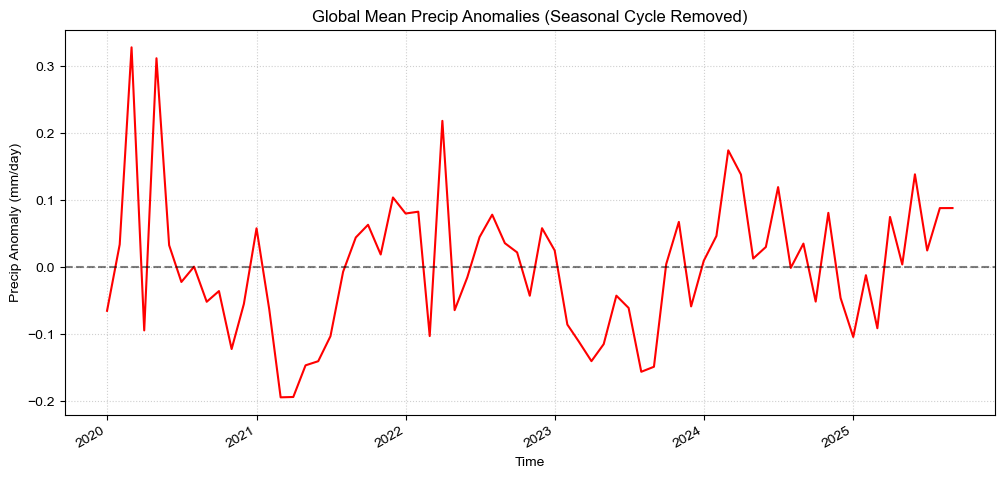

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable  # 用于精确控制色带高度
import numpy as np

# 1. 先读取一个文件打印字段信息
print("=== 单个文件信息 (precip.2020.nc) ===")
try:
    ds_single = xr.open_dataset('precip.2020.nc')
    print(ds_single)
except:
    print("未找到文件，请确保文件在当前目录下。")
print("=====================================")

# 2. 读取所有文件 (2020-2024)
# 使用 parallel=True 加速读取
ds = xr.open_mfdataset('precip.202*.nc', combine='by_coords', parallel=True)

# 提取变量 (假设变量名为 'precip'，如果报错请改为 'pr' 或 'tp')
da_daily = ds['precip']

# 3. 数据重采样：将日数据转为月平均数据
da_monthly = da_daily.resample(time='1MS').mean(keep_attrs=True)

# 4. 计算去季节性距平 (Deseasonalized Anomalies)
# 步骤 A: 计算气候态
climatology = da_monthly.groupby('time.month').mean('time')
# 步骤 B: 计算距平
anomalies = da_monthly.groupby('time.month') - climatology

# 5. 绘图：全球平均的距平时间序列
plt.figure(figsize=(12, 5))
# 对经纬度求平均
ts_anomalies = anomalies.mean(dim=['lat', 'lon'])
ts_anomalies.plot(color='red', linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Global Mean Precip Anomalies (Seasonal Cycle Removed)')
plt.ylabel('Precip Anomaly (mm/day)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

Loading data...
Data loaded successfully.


C:\Users\wsd\AppData\Local\Temp\ipykernel_34512\1291094929.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_c.boxplot(box_data, patch_artist=True, labels=box_labels, widths=0.6,
C:\Users\wsd\AppData\Local\Temp\ipykernel_34512\1291094929.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


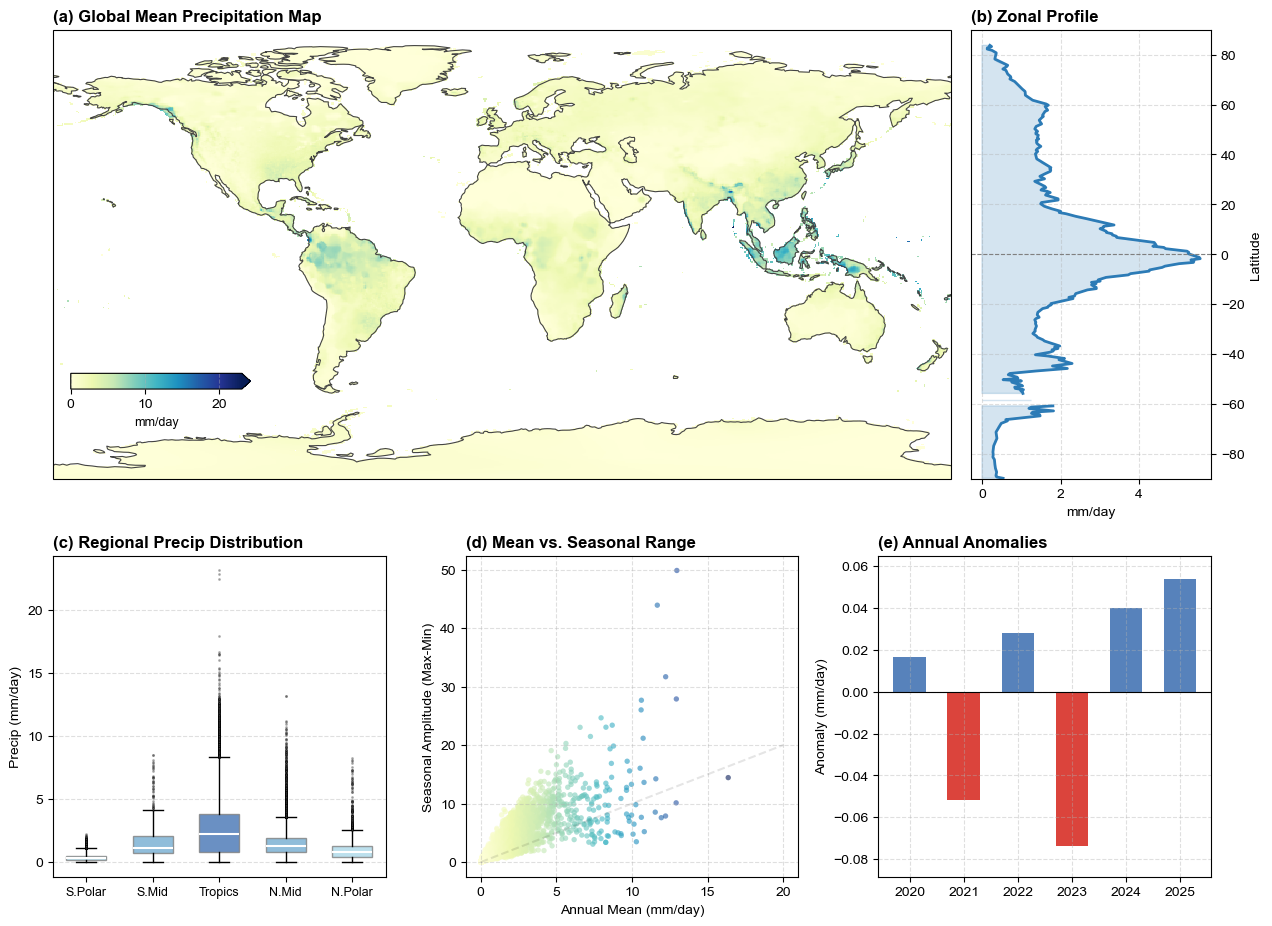

Final Dashboard Generated (Compact & Clean).


In [25]:
# %% [Markdown]
# # Part 1: 数据预处理
# 读取数据并计算统计量。

# %% [Code]
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs


# 1. 风格设置
plt.style.use('fast') 
plt.rcParams.update({
    'font.family': 'sans-serif',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'grid.linestyle': '--'
})

# 2. 读取数据
print("Loading data...")
try:
    ds = xr.open_mfdataset('precip.202*.nc', combine='by_coords', parallel=True)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    ds = ds.sortby(['lat', 'lon'])
    da = ds['precip']
    da_monthly = da.resample(time='1MS').mean(keep_attrs=True)
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

# 3. 预计算绘图数据
clim_mean = da_monthly.mean(dim='time')
zonal_clim = clim_mean.mean(dim='lon')

def get_zone_data(lat_min, lat_max):
    subset = clim_mean.sel(lat=slice(lat_min, lat_max))
    return subset.values.flatten()

zones = {
    'S.Polar': get_zone_data(-90, -60),
    'S.Mid': get_zone_data(-60, -30),
    'Tropics': get_zone_data(-30, 30),
    'N.Mid': get_zone_data(30, 60),
    'N.Polar': get_zone_data(60, 90)
}
box_data = [z[~np.isnan(z)] for z in zones.values()]
box_labels = list(zones.keys())

# 散点图数据
flat_mean = clim_mean.values.flatten()
clim_cycle = da_monthly.groupby('time.month').mean('time')
seasonal_range = (clim_cycle.max(dim='month') - clim_cycle.min(dim='month'))
flat_range = seasonal_range.values.flatten()
valid_mask = ~np.isnan(flat_mean) & ~np.isnan(flat_range)
scatter_x_mean = flat_mean[valid_mask]
scatter_y_range = flat_range[valid_mask]

# 柱状图数据
annual_mean = da_monthly.groupby('time.year').mean(dim=['time', 'lat', 'lon'])
overall_mean = da_monthly.mean()
annual_anom = annual_mean - overall_mean
years = annual_anom.year.values


# %% [Markdown]
# # Part 2: 绘制完美对齐的仪表盘
# 优化了布局参数，使其在保持不重叠的前提下更加紧凑。

# %% [Code]
# [修改]: 稍微减小画布高度 (12 -> 11)，使整体更紧凑
fig = plt.figure(figsize=(20, 11))

# [修改]: hspace 设为 0.2 (既不拥挤也不空旷)，之前是 0.25
gs = gridspec.GridSpec(2, 6, height_ratios=[1.4, 1], hspace=0.2)

# -----------------------------------------------------------------------------
# Row 1: Map + Zonal
# -----------------------------------------------------------------------------
ax_a = fig.add_subplot(gs[0, 0:5], projection=ccrs.PlateCarree())
im_a = clim_mean.plot(ax=ax_a, transform=ccrs.PlateCarree(), cmap='YlGnBu', add_colorbar=False, vmin=0)
ax_a.coastlines(resolution='110m', linewidth=0.8, color='#444444')
ax_a.set_title('(a) Global Mean Precipitation Map', fontweight='bold', loc='left')
cax_a = ax_a.inset_axes([0.02, 0.2, 0.2, 0.035])
cbar_a = plt.colorbar(im_a, cax=cax_a, orientation='horizontal', extend='max')
cbar_a.set_label('mm/day', fontsize=9)

ax_b = fig.add_subplot(gs[0, 5])
ax_b.plot(zonal_clim, zonal_clim.lat, color='#2c7bb6', linewidth=2)
ax_b.fill_betweenx(zonal_clim.lat, 0, zonal_clim, color='#2c7bb6', alpha=0.2)
ax_b.set_ylim(-90, 90)
ax_b.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax_b.set_title('(b) Zonal Profile', fontweight='bold', loc='left')
ax_b.yaxis.tick_right()
ax_b.yaxis.set_label_position("right")
ax_b.set_ylabel('Latitude')
ax_b.set_xlabel('mm/day')

# -----------------------------------------------------------------------------
# Row 2: (c) Box Plot, (d) Scatter, (e) Bar Chart
# -----------------------------------------------------------------------------
ax_c = fig.add_subplot(gs[1, 0:2])
bp = ax_c.boxplot(box_data, patch_artist=True, labels=box_labels, widths=0.6,
                  flierprops=dict(marker='.', markerfacecolor='#999999', markersize=2, alpha=0.3))
colors = ['#abd9e9', '#74add1', '#4575b4', '#74add1', '#abd9e9']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)
    patch.set_edgecolor('gray')
for median in bp['medians']:
    median.set(color='white', linewidth=1.5)
ax_c.set_title('(c) Regional Precip Distribution', fontweight='bold', loc='left')
ax_c.set_ylabel('Precip (mm/day)')
ax_c.tick_params(axis='x', labelsize=9) 
ax_c.grid(axis='x', alpha=0)

ax_d = fig.add_subplot(gs[1, 2:4])
if len(scatter_x_mean) > 5000:
    idx = np.random.choice(len(scatter_x_mean), 5000, replace=False)
    sx, sy = scatter_x_mean[idx], scatter_y_range[idx]
else:
    sx, sy = scatter_x_mean, scatter_y_range
sc = ax_d.scatter(sx, sy, c=sx, cmap='YlGnBu', s=15, alpha=0.6, edgecolors='none')
ax_d.set_title('(d) Mean vs. Seasonal Range', fontweight='bold', loc='left')
ax_d.set_xlabel('Annual Mean (mm/day)')
ax_d.set_ylabel('Seasonal Amplitude (Max-Min)')
ax_d.plot([0, 20], [0, 20], 'k--', alpha=0.1) 

ax_e = fig.add_subplot(gs[1, 4:6])
bar_colors = ['#4575b4' if x >= 0 else '#d73027' for x in annual_anom.values]
ax_e.bar(years, annual_anom.values, color=bar_colors, alpha=0.9, width=0.6)
ax_e.axhline(0, color='black', linewidth=0.8)
ax_e.set_title('(e) Annual Anomalies', fontweight='bold', loc='left')
ax_e.set_ylabel('Anomaly (mm/day)')
ax_e.set_xticks(years)
if len(annual_anom) > 0:
    ax_e.set_ylim(min(annual_anom)*1.2, max(annual_anom)*1.2)


plt.tight_layout()
fig.canvas.draw() 

# 1. 对齐第一行
box_a = ax_a.get_position()
gap = 0.01
new_b_left = box_a.x1 + gap
b_width = 0.12
ax_b.set_position([new_b_left, box_a.y0, b_width, box_a.height])

# 2. 计算第一行总宽度
total_left = box_a.x0
total_right = new_b_left + b_width
total_width = total_right - total_left

# 3. 强制调整第二行
bottom_y0 = ax_c.get_position().y0
bottom_height = ax_c.get_position().height

# [保持]: gap_bottom 维持 0.08，这对于防止水平方向的文字重叠至关重要
gap_bottom = 0.04
single_plot_width = (total_width - 2 * gap_bottom) / 3

# 应用位置
ax_c.set_position([total_left, bottom_y0, single_plot_width, bottom_height])
ax_d.set_position([total_left + single_plot_width + gap_bottom, bottom_y0, single_plot_width, bottom_height])
ax_e.set_position([total_left + 2*single_plot_width + 2*gap_bottom, bottom_y0, single_plot_width, bottom_height])
plt.show()
